In [1]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

Using TensorFlow backend.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/learn-env/lib/p

In [2]:
# uncomment to load
with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [4]:
df.genre.value_counts(normalize=True)

modern          0.292276
metropolitan    0.249543
pre_1900        0.237888
avant_garde     0.220293
Name: genre, dtype: float64

In [5]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df['genre']

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3282, 8) (3282,)
(1094, 8) (1094,)


## Baseline model -- tf-idf vectors only

In [7]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [8]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [9]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

CPU times: user 4.17 s, sys: 543 ms, total: 4.71 s
Wall time: 4.32 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [10]:
%%time

# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.6066422912858014
F1 score: 0.6087765944613979

-----TEST-----
Accuracy: 0.4670932358318099
F1 score: 0.4253300995343577

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.61      0.08      0.15       241
 avant_garde       0.66      0.34      0.45       273
      modern       0.37      0.92      0.53       320
    pre_1900       0.77      0.41      0.53       260

    accuracy                           0.47      1094
   macro avg       0.60      0.44      0.41      1094
weighted avg       0.59      0.47      0.43      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 20  33 179   9]
 [ 12  92 160   9]
 [  1  12 293  14]
 [  0   3 151 106]]
CPU times: user 6.43 s, sys: 774 ms, total: 7.21 s
Wall time: 5.98 s


In [11]:
X_train_vec

,aaa,aaaall,aalto,aaron,abacus,abandon,abandonment,abase,abash,abate,...,zuan,zummer,zun,zunbrowned,zunburnt,zunlight,zunny,zuns,zvak,zwim
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [13]:
print(np.take(X_train_vec.columns, metro_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, modern_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, avant_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, pre1900_class_prob_sorted[:10]))

Index(['aaaall', 'aaron', 'aalto', 'aaa'], dtype='object')
Index(['aaa', 'migratorious', 'milan', 'milder', 'mildness', 'miletus',
       'milholland', 'militarisme', 'milked', 'milkmaid'],
      dtype='object')
Index(['zwim', 'hoper', 'hopped', 'shipwright', 'hopscotch', 'horace',
       'horatian', 'shipwreck', 'horeb', 'shipwrack'],
      dtype='object')
Index(['aaa', 'grievings', 'rouchled', 'rotunda', 'rottenness', 'grig',
       'rotor', 'grille', 'roto', 'grimace'],
      dtype='object')


In [14]:
bnb_baseline_vec.feature_log_prob_.argsort()

array([[28278, 12581, 22554, ..., 14916, 21431, 21146],
       [    0, 15595, 15597, ..., 21431, 21146, 14916],
       [28278, 11863, 11864, ...,  8739, 16556, 14609],
       [    0, 10812, 20741, ..., 21431, 14609,  6199]])

In [15]:
metro_class_prob_sorted

array([1, 3, 2, 0])

#### Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
## Baseline model -- vectors + numerical data

#### Dataframe creation

In [16]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

#### Scale and combine

In [17]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [19]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

#### Model

In [20]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

CPU times: user 9.04 s, sys: 1.6 s, total: 10.6 s
Wall time: 10.3 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
%%time

# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.6096892138939671
F1 score: 0.612164783557265

-----TEST-----
Accuracy: 0.4670932358318099
F1 score: 0.4262879661539977

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.61      0.08      0.15       241
 avant_garde       0.66      0.34      0.45       273
      modern       0.37      0.91      0.53       320
    pre_1900       0.77      0.41      0.53       260

    accuracy                           0.47      1094
   macro avg       0.60      0.44      0.41      1094
weighted avg       0.59      0.47      0.43      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 20  34 179   8]
 [ 11  94 159   9]
 [  2  12 291  15]
 [  0   3 151 106]]
CPU times: user 12.8 s, sys: 2.18 s, total: 14.9 s
Wall time: 13.7 s


#### Practically the same result

## Decision Tree -- tf-idf vectors only
#### Let's first take a quick look at cross validation scores

In [22]:
# instantiate the naive bayes classifier
tree_vec = DecisionTreeClassifier()

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.40425532, 0.40729483, 0.39329268, 0.39939024, 0.3902439 ,
       0.39329268, 0.41158537, 0.40243902, 0.42378049, 0.42682927])

#### Naive Bayes performs better
## Decision Tree -- vectors and numerical data
#### Look at cross validation scores

In [23]:
# instantiate the decision classifier
tree_combo = DecisionTreeClassifier()

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.54103343, 0.48632219, 0.50609756, 0.45121951, 0.49085366,
       0.48780488, 0.50914634, 0.49695122, 0.49085366, 0.45731707])

#### Notable improvement so let's fit a model

In [24]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 9.34 s, sys: 1.16 s, total: 10.5 s
Wall time: 10.5 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [25]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 0.9993906154783668
F1 score: 0.9993903971862134

-----TEST-----
Accuracy: 0.4716636197440585
F1 score: 0.47004389709255623

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.48      0.46      0.47       241
 avant_garde       0.42      0.36      0.39       273
      modern       0.41      0.45      0.43       320
    pre_1900       0.58      0.62      0.60       260

    accuracy                           0.47      1094
   macro avg       0.47      0.47      0.47      1094
weighted avg       0.47      0.47      0.47      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[112  59  63   7]
 [ 51  99  86  37]
 [ 55  50 145  70]
 [ 14  28  58 160]]
CPU times: user 7.7 s, sys: 1.53 s, total: 9.23 s
Wall time: 9.23 s


#### Definitely better than our Naive Bayes model
### Decision Tree - Feature importances

In [26]:
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'num_end_rhymes': 0.11007585654210111,
 'avg_len_line': 0.06060389285626467,
 'avg_syllables_word': 0.05830843115964017,
 'num_lines': 0.05269643035199075,
 'sentiment_polarity_score': 0.02258363492583386,
 'sentiment_subjectivity_score': 0.020310951818931028,
 'get': 0.014781807450453481,
 'light': 0.00892308241672876,
 'know': 0.007713988035427452,
 'little': 0.0070537491209945935}

## Random Forest -- tf-idf vectors only
#### Let's first take a quick look at cross validation scores

In [27]:
# instantiate the naive bayes classifier
forest_vec = RandomForestClassifier()

# fit it to our training set and evaluate
cross_val_score(forest_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.56838906, 0.56534954, 0.55792683, 0.5152439 , 0.56707317,
       0.58536585, 0.57012195, 0.55182927, 0.55792683, 0.57926829])

## Random Forest -- vectors and numerical data

In [28]:
# instantiate the decision classifier
forest_combo = RandomForestClassifier()

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.58054711, 0.63221884, 0.64634146, 0.58536585, 0.62804878,
       0.59146341, 0.59146341, 0.6097561 , 0.58841463, 0.62195122])

In [29]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 19.8 s, sys: 1.18 s, total: 21 s
Wall time: 21 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [30]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 0.9993906154783668
F1 score: 0.9993903971862134

-----TEST-----
Accuracy: 0.6261425959780622
F1 score: 0.6213792967901269

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.68      0.46      0.55       241
 avant_garde       0.62      0.52      0.56       273
      modern       0.54      0.73      0.62       320
    pre_1900       0.73      0.77      0.75       260

    accuracy                           0.63      1094
   macro avg       0.64      0.62      0.62      1094
weighted avg       0.64      0.63      0.62      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[110  59  58  14]
 [ 32 141  84  16]
 [ 19  24 233  44]
 [  0   3  56 201]]
CPU times: user 7.87 s, sys: 1.5 s, total: 9.37 s
Wall time: 9.38 s


In [31]:
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'num_end_rhymes': 0.020076914328688845,
 'avg_len_line': 0.016599447912066877,
 'avg_syllables_word': 0.010609575975566466,
 'num_lines': 0.008350060082588609,
 'sentiment_polarity_score': 0.008100964810189928,
 'sentiment_subjectivity_score': 0.006233650462750479,
 'heart': 0.0035447417431501284,
 'get': 0.0032271297790378356,
 'day': 0.0031789311325537114,
 'sweet': 0.0030092352589805044}

## SVM Model - tf-idf vectors only

In [36]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 11min 23s, sys: 4.31 s, total: 11min 27s
Wall time: 11min 33s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
%%time

# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.9686166971358927
F1 score: 0.9685752094288665

-----TEST-----
Accuracy: 0.6261425959780622
F1 score: 0.6247558000810909

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.54      0.44      0.48       241
 avant_garde       0.58      0.61      0.60       273
      modern       0.57      0.67      0.62       320
    pre_1900       0.82      0.77      0.80       260

    accuracy                           0.63      1094
   macro avg       0.63      0.62      0.62      1094
weighted avg       0.63      0.63      0.62      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[105  68  62   6]
 [ 41 167  55  10]
 [ 38  42 213  27]
 [  9   9  42 200]]
CPU times: user 9min 49s, sys: 2.07 s, total: 9min 51s
Wall time: 9min 53s


In [ ]:
coef_svm = pd.DataFrame(np.array(svm_vec.coef_))
# coef_df['tokens'] = vectorizer.get_feature_names()
# coef_df.set_index()
coef_svm.head()

In [ ]:
dict(zip(svm_vec.coef_, X_train_vec_df.columns))

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = np.ravel(classifier.coef_)
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
#     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], 
#             color=colors
           )
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [ ]:
plot_coefficients(svm_vec, X_train_vec_df.columns)

In [ ]:
list(zip(svm_vec.coef_[:,0], X_train_vec_df.columns))

In [ ]:
feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(svm_vec.coef_[:,0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')

In [ ]:
svm_vec.coef_[:,0]

In [ ]:
svm_vec.coef_[0,0]

In [ ]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(svm_vec.coef_[0]), feature_names, top=10)

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances(svm_vec.coef_, X_train_vec_df.columns)

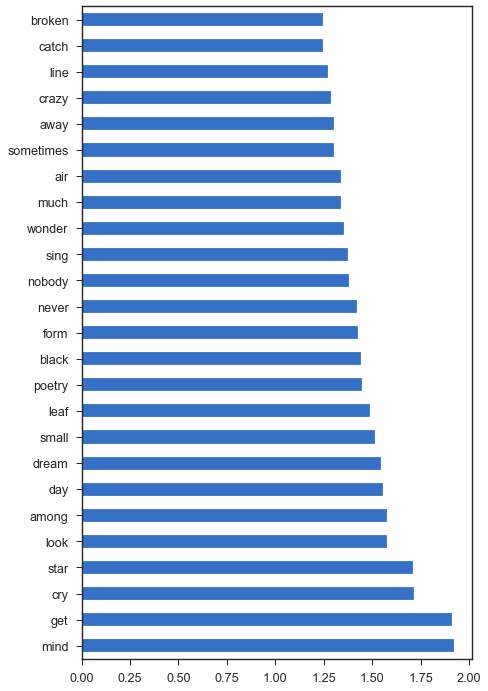

In [57]:
plt.figure(figsize=(7,12))
pd.Series(abs(svm_vec.coef_[0]), index=X_train_vec.columns).nlargest(25).plot(kind='barh')

#### Quite a bump! very overfit, but let's see if it works any better with our combo dataframes
## SVM - vectors + numerical data

In [38]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 9min 39s, sys: 2.77 s, total: 9min 42s
Wall time: 9min 43s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9573430834856794
F1 score: 0.9572124926829236

-----TEST-----
Accuracy: 0.6755027422303473
F1 score: 0.6752703596917183

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.68      0.59      0.63       241
 avant_garde       0.63      0.63      0.63       273
      modern       0.61      0.66      0.63       320
    pre_1900       0.81      0.82      0.81       260

    accuracy                           0.68      1094
   macro avg       0.68      0.68      0.68      1094
weighted avg       0.68      0.68      0.68      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[142  53  42   4]
 [ 29 173  60  11]
 [ 30  43 212  35]
 [  9   5  34 212]]
CPU times: user 10min 15s, sys: 2.9 s, total: 10min 18s
Wall time: 10min 19s


In [49]:
def f_importances(coef, names, amt):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp, names)))[:amt]
    plt.barh(range(amt), imp, align='center')
    plt.yticks(range(amt), names[:amt])
    plt.show()

In [51]:
f_importances(svm_combo.coef_, X_train_combo.columns, 20)

TypeError: 'zip' object is not subscriptable

In [44]:
coef_svm = pd.DataFrame(svm_combo.coef_[0], columns=['coefficient'], index=X_train_combo.columns).\
                        sort_values(by=['coefficient'], ascending=False)
coef_svm

,coefficient
among,1.835010
leaf,1.405554
small,1.315754
mind,1.314159
form,1.306792
...,...
look,-1.572884
dream,-1.618399
get,-1.634151
black,-1.681018


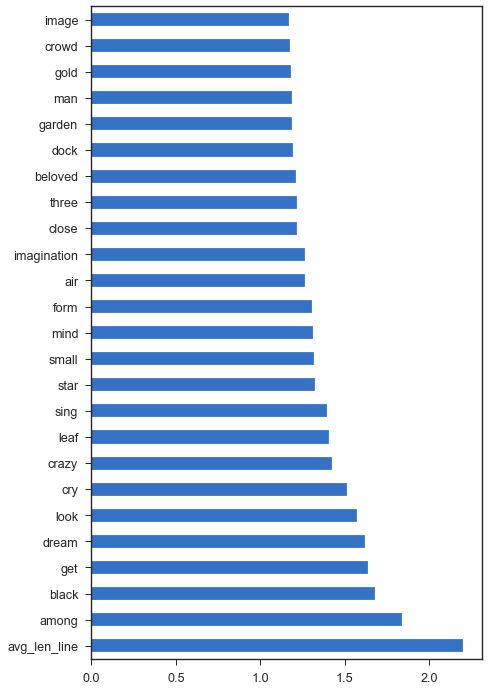

In [54]:
sns.set_style('ticks')

plt.figure(figsize=(7,12))
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(25).plot(kind='barh')

#### Still overfit but nearly a 10% increase in our test predictions!

In [40]:
%%time

# instantiate the model
svm_combo2 = SVC(C=2, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 10min 53s, sys: 2.79 s, total: 10min 56s
Wall time: 10min 57s


SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.9951249238269348
F1 score: 0.9951215811379879

-----TEST-----
Accuracy: 0.6782449725776966
F1 score: 0.6782315773457501

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.63      0.60      0.62       241
 avant_garde       0.62      0.65      0.64       273
      modern       0.64      0.64      0.64       320
    pre_1900       0.83      0.83      0.83       260

    accuracy                           0.68      1094
   macro avg       0.68      0.68      0.68      1094
weighted avg       0.68      0.68      0.68      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[145  52  41   3]
 [ 38 177  47  11]
 [ 39  46 205  30]
 [  8   9  28 215]]
CPU times: user 10min 12s, sys: 2.85 s, total: 10min 15s
Wall time: 10min 16s


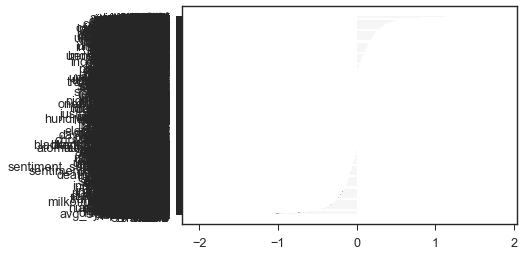

In [45]:
f_importances(svm_combo2.coef_, X_train_combo.columns)

In [46]:
%%time

# instantiate the model
svm_combo3 = SVC(C=3, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo3.fit(X_train_combo, y_train)

CPU times: user 11min 24s, sys: 3.34 s, total: 11min 27s
Wall time: 11min 29s


SVC(C=3, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo3 = svm_combo3.predict(X_train_combo)
y_test_preds_svm_combo3 = svm_combo3.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train3 = accuracy_score(y_train, y_train_preds_svm_combo3)
svm_combo_f1_train3 = f1_score(y_train, y_train_preds_svm_combo3, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train3}')
print(f'F1 score: {svm_combo_f1_train3}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test3 = accuracy_score(y_test, y_test_preds_svm_combo3)
svm_combo_f1_test3 = f1_score(y_test, y_test_preds_svm_combo3, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test3}')
print(f'F1 score: {svm_combo_f1_test3}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo3, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo3))

-----TRAIN-----
Accuracy: 0.9987812309567337
F1 score: 0.9987812767455831

-----TEST-----
Accuracy: 0.6663619744058501
F1 score: 0.6668505678067502

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.62      0.61      0.61       241
 avant_garde       0.62      0.63      0.63       273
      modern       0.62      0.63      0.62       320
    pre_1900       0.82      0.80      0.81       260

    accuracy                           0.67      1094
   macro avg       0.67      0.67      0.67      1094
weighted avg       0.67      0.67      0.67      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[146  48  42   5]
 [ 39 173  50  11]
 [ 41  49 201  29]
 [  8  10  33 209]]
CPU times: user 10min 15s, sys: 2.93 s, total: 10min 18s
Wall time: 10min 19s


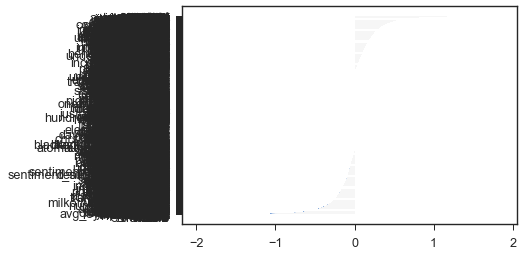

In [48]:
f_importances(svm_combo3.coef_, X_train_combo.columns)

In [ ]:
please break my code

## LSTM Neural Net -- tf-idf vectors only
#### First we need to convert our target classes into numbers

In [ ]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
y_train_le = le.fit_transform(y_train)

# transfomr the target test set
y_test_le = le.transform(y_test)

#### The following code--including vocab_size, embedding_dim, and num_epochs--based on work by from Susan Li (https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35)

In [ ]:
vocab_size = 10000
embedding_dim = 64

In [ ]:
model = Sequential([
    # add an Embedding layer expecting input vocab of size 5000,
    # and output embedding dimension of size 64 we set at the top
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(embedding_dim)),
    Dense(embedding_dim, activation='relu'),
    # add a Dense layer with 6 units and softmax activation, since we have multiple classes
    Dense(6, activation='softmax')
])

model.summary()

In [ ]:
%%time

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 5
history = model.fit(X_train_vec, y_train_le, epochs=num_epochs,
                    validation_data=(X_test_vec, y_test_le), verbose=2)